In [1]:
import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd
import sys
import h5py
import matplotlib.pyplot as plt
import yaml

In [2]:
from tqdm import tqdm
from chainconsumer import Chain, ChainConsumer, make_sample

In [3]:
import torch
from typing import List
import torch.nn as nn
from typing import OrderedDict

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.embedding import FCN

# Check that we are on GPU node
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

ncpus = len(os.sched_getaffinity(0))
print("Our node allocation is %i cpus"%ncpus)

Device: cuda
Our node allocation is 16 cpus


In [4]:
## CNN 1D embedding Matt
class CNN1DEmbedding(nn.Module):
    """1D CNN network with fully connected layers to compress data.

    Args:
        n_filters (List[int]): number of filters per convolutional layer
        kernel_sizes (List[int]): kernel sizes per convolutional layer
        strides (List[int]): stride values per convolutional layer
        pool_sizes (List[int]): pooling sizes per convolutional layer
        fc_hidden (List[int]): number of hidden units per fully connected layer
        act_fn (str): activation function to use
    """

    def __init__(
        self, n_filters: List[int], kernel_sizes: List[int],
        strides: List[int], pool_sizes: List[int],
        fc_hidden: List[int], act_fn: str = "SiLU"
    ):
        super().__init__()
        self.act_fn = getattr(nn, act_fn)()
        self.n_layers = len(n_filters) + len(pool_sizes)
        self.n_filters = n_filters
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.pool_sizes = pool_sizes
        self.fc_hidden = fc_hidden

    def initialize_model(self, n_input: int):
        """Initialize network once the input dimensionality is known.

        Args:
            n_input (int): input dimensionality
        """
        # Convolutional layers
        conv_model = []
        n_left = n_input
        layer, iconv, ipool = 0, 0, 0
        while layer < self.n_layers:
            if layer % 3 == 2:
                pass
                conv_model.append((f"pool{ipool}", nn.MaxPool1d(
                    kernel_size=self.pool_sizes[ipool],
                    stride=self.pool_sizes[ipool]
                )))
                n_left = n_left // self.pool_sizes[ipool]
                ipool += 1
            else:
                conv_model.append((f"conv{iconv}", nn.Conv1d(
                    in_channels=1 if layer == 0 else self.n_filters[iconv - 1],
                    out_channels=self.n_filters[iconv],
                    kernel_size=self.kernel_sizes[iconv],
                    stride=self.strides[iconv],
                    padding=self.kernel_sizes[iconv]//2
                )))
                conv_model.append((f"act{iconv}", self.act_fn))
                n_left = (n_left - self.kernel_sizes[iconv] +
                          self.kernel_sizes[iconv]) // self.strides[iconv]
                iconv += 1
            layer += 1

        self.conv = nn.Sequential(OrderedDict(conv_model))

        # Fully connected layers
        fc_model = []
        fc_input_size = self.n_filters[-1] * n_left
        for layer, hidden_units in enumerate(self.fc_hidden):
            fc_model.append((f"fc{layer}", nn.Linear(
                fc_input_size if layer == 0 else self.fc_hidden[layer - 1],
                hidden_units
            )))
            fc_model.append((f"act_fc{layer}", self.act_fn))

        self.fc = nn.Sequential(OrderedDict(fc_model))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the neural network, returns the compressed data
        vector.

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor: data
        """
        x = x.unsqueeze(1)  # Add a channel dimension (1D convolution)
        x = self.conv(x).squeeze(-1)
        x = self.fc(x)
        return x

# 0) Preliminaries

## Convenience functions

In [5]:
def retrieve_keys(f):
    return [key for key in f.keys()]

main_key = "0.666667"

## Paths and data loading

REMINDER: the shape for X must be (N,dim(x)) and for Theta (M, dim(theta))

In [21]:
matt_path = "/data80/mattho/cmass-ili/2gpch_0704/borgpm/L2000-N256/"
abacus_path = "/data80/mattho/cmass-ili/abacus/nbody/L2000-N256/"
sys.path.append(matt_path)

# For specific HOD if gal
hod_str = "hod00000"

In [7]:
c_r = 0
seeds_rho = []
for r in tqdm(os.listdir(matt_path)):
    if os.path.exists(matt_path + r + "/diag/rho.h5"):
        c_r+=1
        seeds_rho.append(int(r))
    else:
        continue

c_h = 0
seeds_halo = []
for r in tqdm(os.listdir(matt_path)):
    if os.path.exists(matt_path + r + "/diag/rho.h5"):
        c_h+=1
        seeds_halo.append(int(r))
    else:
        continue

c_g = 0
seeds_gal = []
for r in tqdm(os.listdir(matt_path)):
    if os.path.exists(matt_path + r + "/diag/galaxies/%s.h5"%hod_str):
        c_g+=1
        seeds_gal.append(int(r))
    else:
        continue

print("%i rho seeds found"%c_r)
print("%i halo seeds found"%c_h)
print("%i gal seeds found"%c_g)

100%|██████████| 1898/1898 [00:00<00:00, 3037.72it/s]

1615 rho seeds found
1615 halo seeds found
1614 gal seeds found


In [8]:
# Only consider seeds that have rho, halo and galaxy statistics availables
inter_list = list(set(seeds_rho) & set(seeds_halo) & set(seeds_gal))

# Retrieve Theta (concatenate rows of cosmo params)
n_p = 5
Theta = np.array([],dtype=np.float32).reshape(0,n_p)

for si in tqdm(inter_list):
    if os.path.exists(matt_path + str(si) + "/config.yaml"):
        with open(matt_path + str(si) + "/config.yaml", "r") as file:
            run_info = yaml.safe_load(file)
            Theta = np.vstack([Theta, np.array(run_info["nbody"]["cosmo"], dtype = np.float32)])

print(Theta.shape)
low_param_bounds =Theta.min(axis=0)
high_param_bounds = Theta.max(axis=0)

100%|██████████| 1614/1614 [00:29<00:00, 54.57it/s]

(1614, 5)


# 1) Rho Inference

For density field statistics, the observation role will be played by an 2Gpc PM run since we don't have the summaries from Abacus

## 1-1) Power spectrum real space
Eeach .h5 file has all its statistics in the main group "0.666667" which correpond 
to the scale factor for $z = 0$.
For $\rho$, the keys inside are just "k" and "Pk"

With $n$ the number of sims, shape(X) = (n,p).

In [9]:
def load_pk_rho(my_path, seed_int, k_min, k_max, col = 0, key_main = main_key):
    # col = 0 to load power spectrum monopole by default
    temp  = h5py.File(my_path + "%s/diag/rho.h5"%str(seed_int), "r")
    data_temp = temp[key_main]

    k_temp = data_temp["k"]
    inds0 = np.where((k_temp[:]>=k_min) & (k_temp[:]<=k_max))[0]

    return data_temp["Pk"][inds0, col] 

In [10]:
# Construct the X array for ltu-ili InferenceRunner
k_low = 1e-2
k_up = 0.3
pk_pole = 0 # for monopole

# Load one file to know vector size and k wavevector
temp  = h5py.File(matt_path + "%s/diag/rho.h5"%str(inter_list[0]), "r")
keyt = retrieve_keys(temp)
data_temp = temp[keyt[0]]

k_temp =data_temp["k"]
inds0 = np.where((k_temp[:]>=k_low) & (k_temp[:]<=k_up))[0]
k_vec = k_temp[inds0]
p_vec = k_vec.shape[0]
print(p_vec)

# Actually fill-in data
pks = np.zeros((len(inter_list), p_vec), dtype = np.float32)

nn = 0
for si in tqdm(inter_list):
    pks[nn,:] = load_pk_rho(matt_path, si, k_low, k_up, col = pk_pole)
    nn+=1

# Filter out null values (as in Matt's inference notebook)
mask = np.all(pks==0, axis=1)
pks = pks[~mask]
Theta_rho = Theta[~mask]
print(Theta[0:])

93


100%|██████████| 1614/1614 [00:05<00:00, 307.03it/s]

[[0.1755  0.06681 0.7737  0.8849  0.6641 ]
 [0.2139  0.05557 0.8599  0.9785  0.8619 ]
 [0.1867  0.04503 0.6189  0.8307  0.7187 ]
 ...
 [0.1611  0.03709 0.8161  1.0743  0.9983 ]
 [0.4017  0.04425 0.8509  0.8251  0.7833 ]
 [0.2953  0.04701 0.8017  0.8193  0.6627 ]]


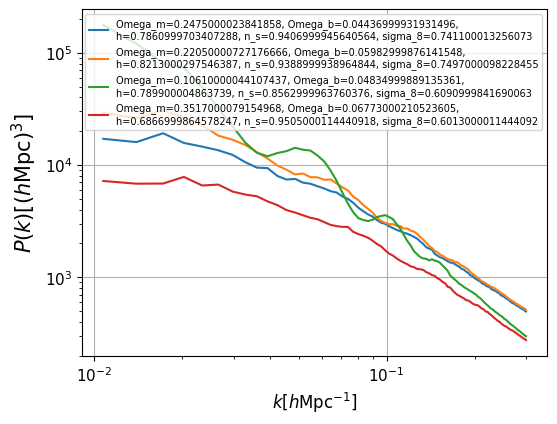

In [11]:
# Sanity check plot
A = plt.figure(figsize = (6,4.5))
for i in [16,23,1312, 916]:
    lstr = f"Omega_m={Theta[i,0]}, Omega_b={Theta[i,1]}, \n"
    lstr += f"h={Theta[i,2]}, n_s={Theta[i,3]}, sigma_8={Theta[i,4]}"
    plt.loglog(k_vec, pks[i,:], label=lstr)
plt.legend(fontsize=7)
plt.grid()
plt.xlabel(r"$k[h\mathrm{Mpc}^{-1}]$", fontsize = 12)
plt.ylabel(r"$P(k)[(h\mathrm{Mpc})^{3}]$", fontsize = 15)
plt.tick_params(labelsize = 11)

In [12]:
# Remove row for observation small test
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
a_ex = a[1,:]
print(a_ex)
a = np.delete(a, 1, axis = 0)
print(a)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[4 5 6]
[[1 2 3]
 [7 8 9]]


In [13]:
# Split data into train, validation (posterior coverage and cie) and observation.

# Perhaps transform data vector
f_rho = lambda pk : np.log10(pk)

# Observation chosen id and remove from pk data for safety. don't forget about Theta
obs_ind = 982
x_0 = f_rho(pks[obs_ind, :])
theta_0 = Theta_rho[obs_ind,:]
print(theta_0) 
pks_rho = np.delete(pks, obs_ind, axis = 0)
Theta_rho = np.delete(Theta_rho, obs_ind, axis = 0)

n_train = 1200
X_rho_train = f_rho(pks_rho[:n_train,:])
Theta_rho_train = Theta_rho[:n_train,:]

n_test = len(inter_list) - n_train - 1 ; print("We have %i test sims left"%n_test) # accounting for observation
X_rho_test = f_rho(pks_rho[n_train:,:])
Theta_rho_test = Theta_rho[n_train:,:]

# Instantiante ILI runner                   
loader = NumpyLoader(x=X_rho_train, theta=Theta_rho_train)

[0.3257  0.06983 0.5835  0.9813  0.6679 ]
We have 413 test sims left


In [14]:
# define a prior
prior = ili.utils.Uniform(low=low_param_bounds, high=high_param_bounds,device=device)

# define a prior to sample parameters from
# Om_low = 0.1 ; Om_high = 0.5.
# Ob_low = 1e-3 ; Ob_high = 0.2
# h_low = 0.3 ; h_high = 0.9
# ns_low = -1. ; ns_high = 1.
# s8_low = 0. ; s8_high = 2*np.pi
# my_prior = ili.utils.Uniform(low=[d_low, q_low, chirp_low, chi_low],
#                           high=[d_high, q_high, chirp_high, chi_high], device=device)

# Embedding network (Comment out everything or one of the other)

activation = "ReLU"
n_hidden = [128, 64, 32]
my_embedding_rho = FCN(n_hidden = n_hidden, act_fn = activation)

# my_embedding = CNN1DEmbedding(
#     n_filters=[32, 16, 8],
#     kernel_sizes=[12, 6, 4],
#     strides=[4, 2, 2],
#     pool_sizes=[4],
#     fc_hidden=n_hidden,
#     act_fn=activation,
# )
# my_embedding.initialize_model(len(x_0))
# print(my_embedding)

In [19]:
#instantiate your neural networks to be used as an ensemble
backend = "sbi"
engine = "NPE"
signatures = ["maf_test","mdn_test"]
hidden_mdn = 50
componenents_mdn = 6
hidden_maf = 50
transforms_maf = 5
nets_rho = [
    ili.utils.load_nde_sbi(engine=engine, model='maf', hidden_features=hidden_maf, num_transforms=transforms_maf),
    ili.utils.load_nde_sbi(engine=engine, model='mdn', hidden_features=hidden_mdn, num_components=componenents_mdn)
]

# instantiate your neural networks to be used as an ensemble
# backend = "lampe"
# engine = "NPE"
# signatures = ["nsf_test","gf_test"]
# hidden_lampe = 50
# transforms_lampe = 5
# nets = [
#     ili.utils.load_nde_lampe(model='nsf', hidden_features=hidden_lampe, num_transforms=transforms_lampe),
#     ili.utils.load_nde_lampe(model='gf', hidden_features=hidden_lampe, num_transforms=transforms_lampe)
# ]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-4,
    'validation_fraction':0.1
}

# initialize the trainer
runner_rho = InferenceRunner.load(
    backend=backend,
    engine=engine,
    prior=prior,
    nets=nets_rho,
    device=device,
    embedding_net=my_embedding_rho,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [20]:
# train the model
posterior_ensemble, summaries = runner_rho(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/chartier/myModules/miniconda/envs/cmass_val/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 218 epochs.

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 127 epochs.

/home/chartier/myModules/miniconda/envs/cmass_val/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 46.59017038345337 seconds to train models.


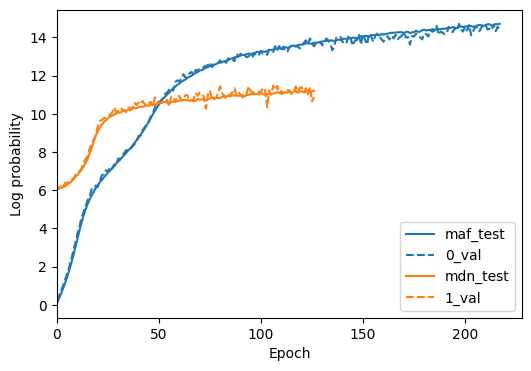

In [22]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f"C{i}" for i in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=signatures[i], c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()


Drawing 968 posterior samples:   0%|          | 0/968 [00:00<?, ?it/s]

Drawing 32 posterior samples:   0%|          | 0/32 [00:00<?, ?it/s]

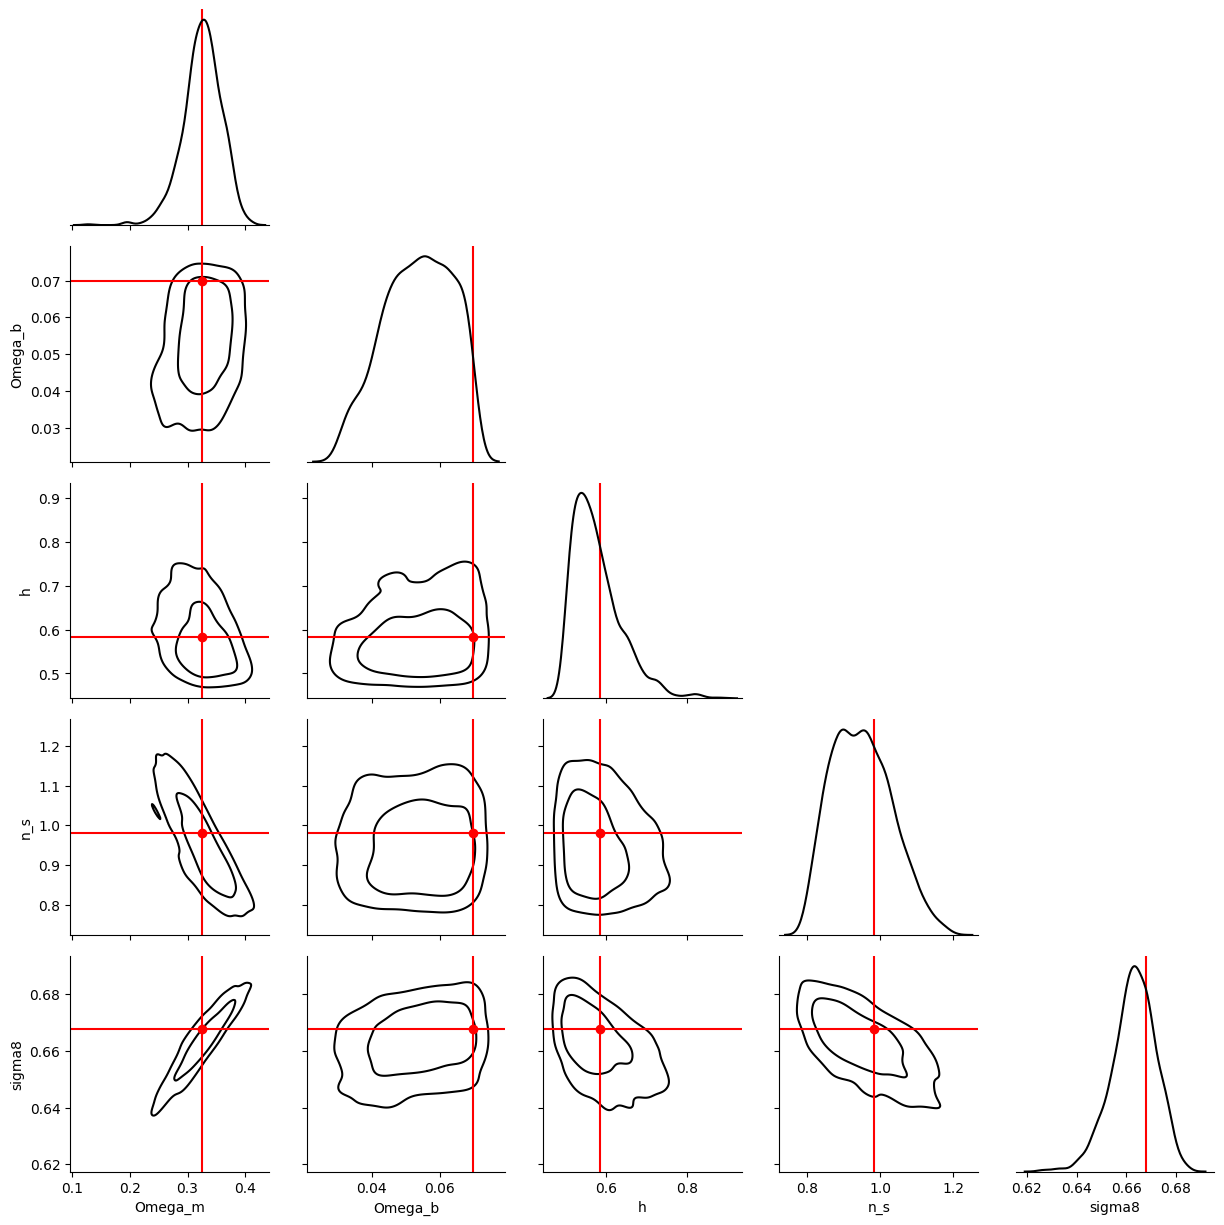

In [23]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
    # labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_0, theta_fid=theta_0
)

 69%|██████▉   | 284/413 [00:06<00:02, 43.15it/s]WARNING:root:Only 0.030% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    29 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
 99%|█████████▉| 409/413 [00:09<00:00, 43.33it/s]WARNING:root:Only 0.080% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    41 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
100%|██████████| 413/413 [00:09<00:00, 42.76it/s]
INFO:root:Mean logprob: 1.4231e+01Median logprob: 1.4478e+01
100%|██████████| 100/100 [00:04<00:00, 23.65it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


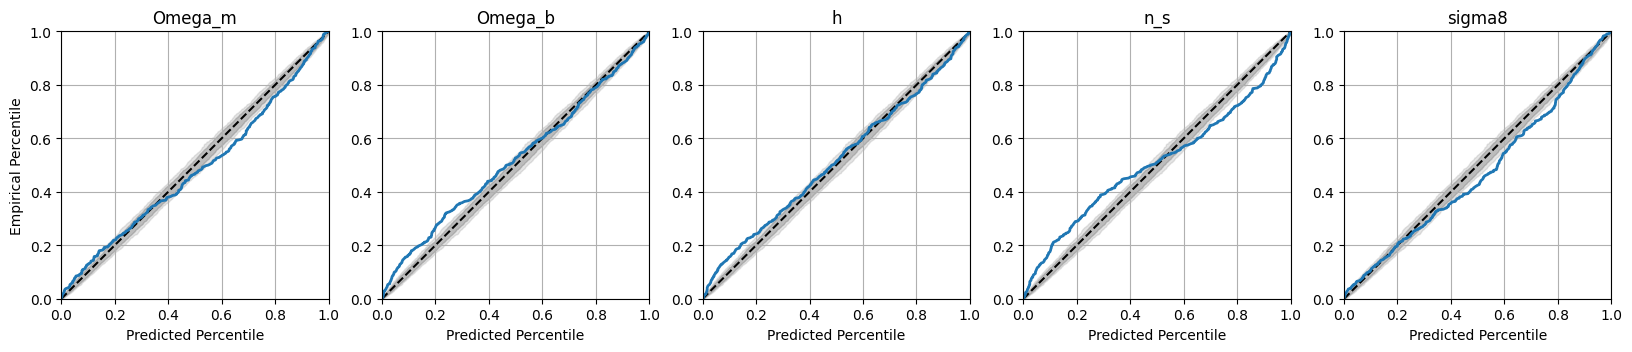

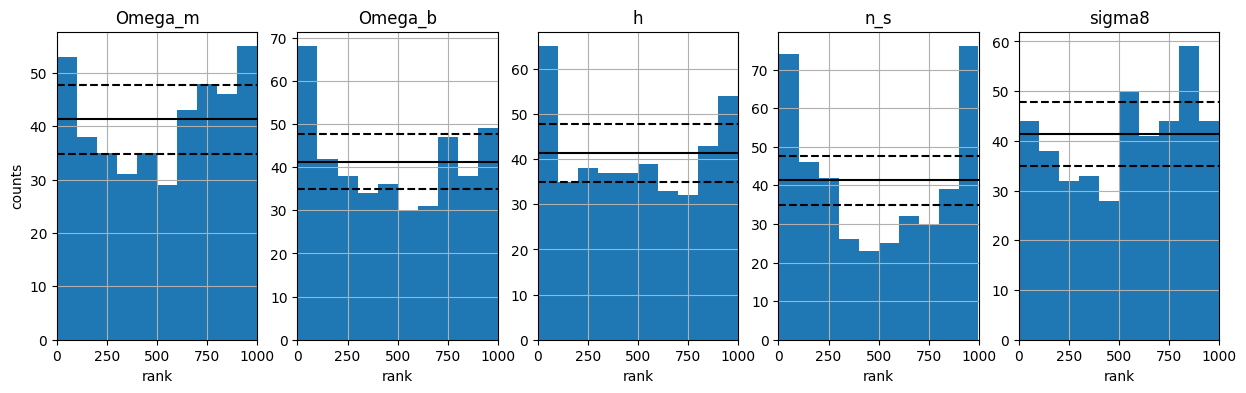

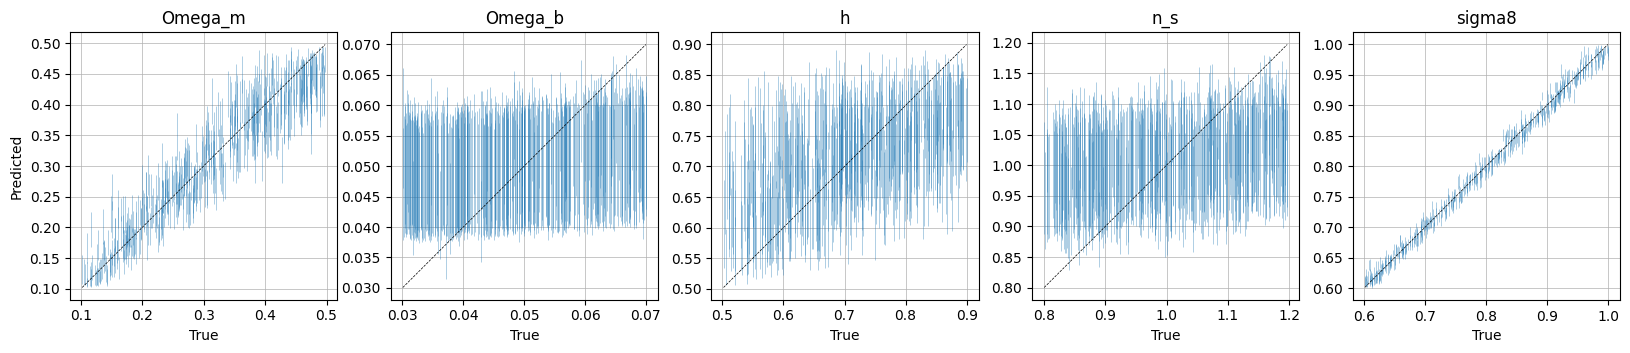

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


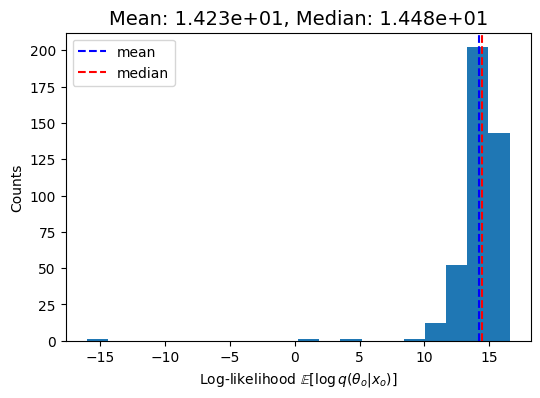

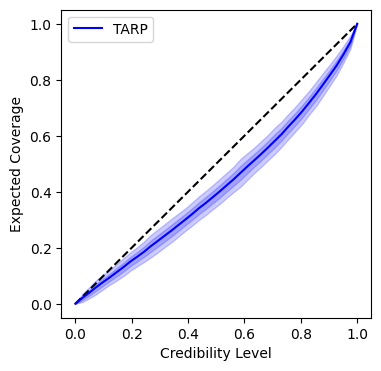

In [24]:
# Drawing samples from the ensemble posterior
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=X_rho_test, theta=Theta_rho_test
)


Before we looked at the "PosteriorEnsemble" instance. Let's have a look at the density estimators in the ensemble separately

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

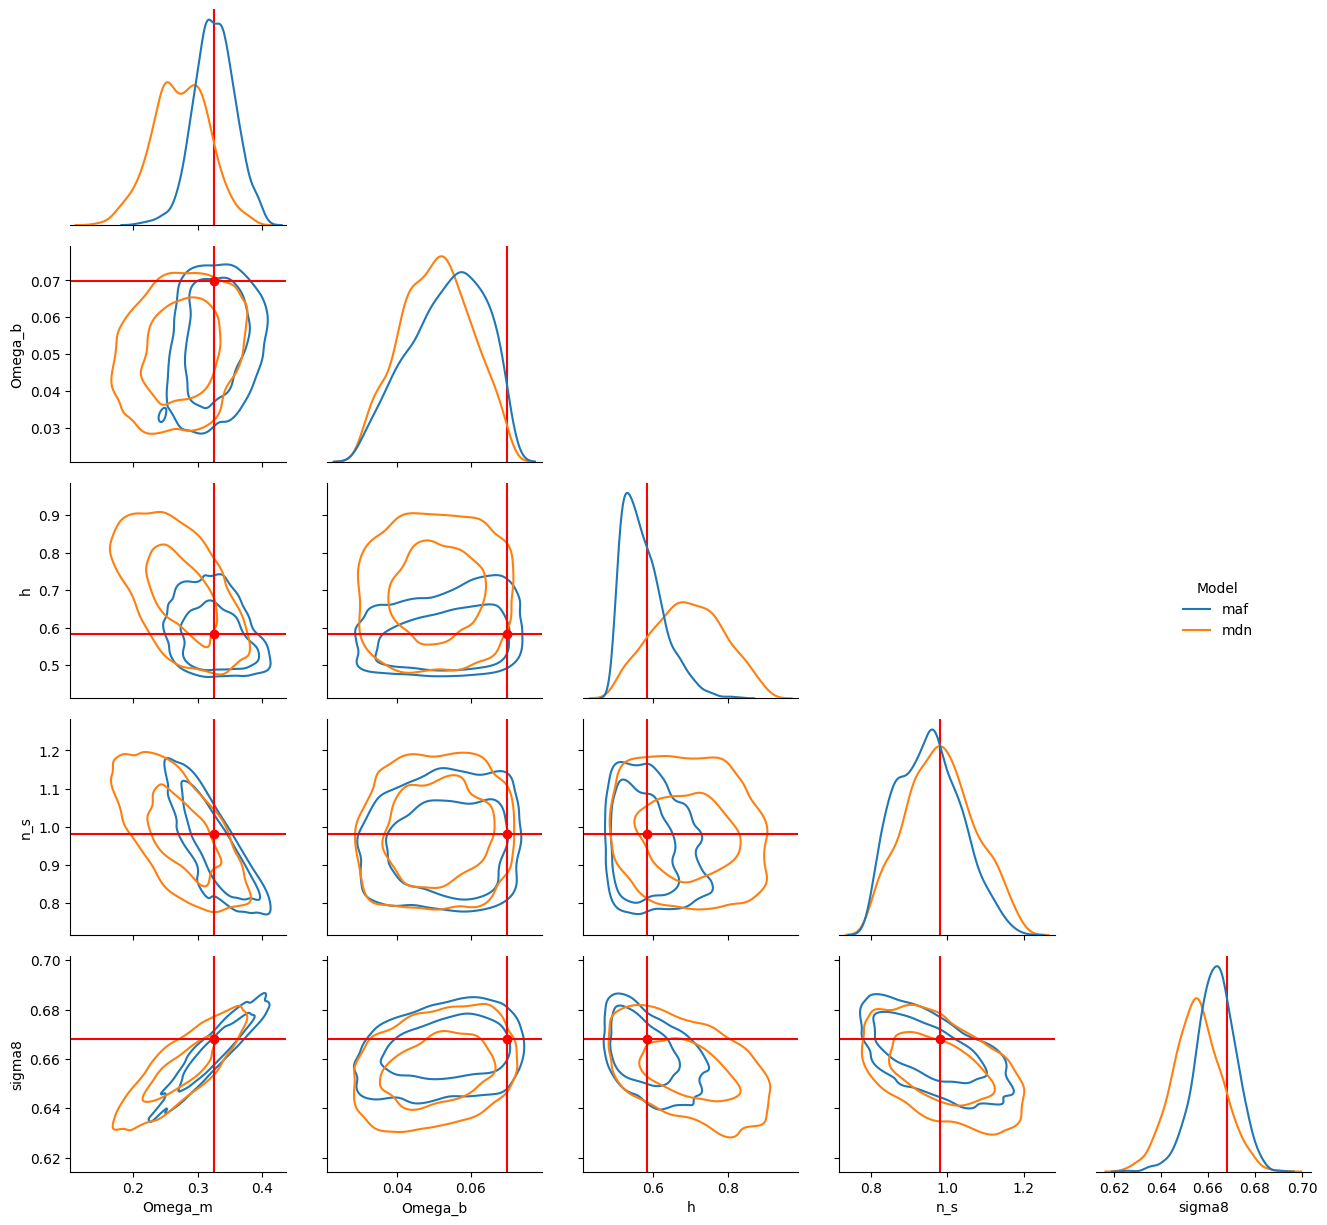

In [25]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x_0, theta_fid=theta_0,
    name='maf'
)
# overplot the posterior for model #2 (MDN)
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x_obs = x_0, theta_fid=theta_0,
    name='mdn',
    grid=fig  # overplot on the same figure
)



100%|██████████| 100/100 [00:04<00:00, 23.53it/s]


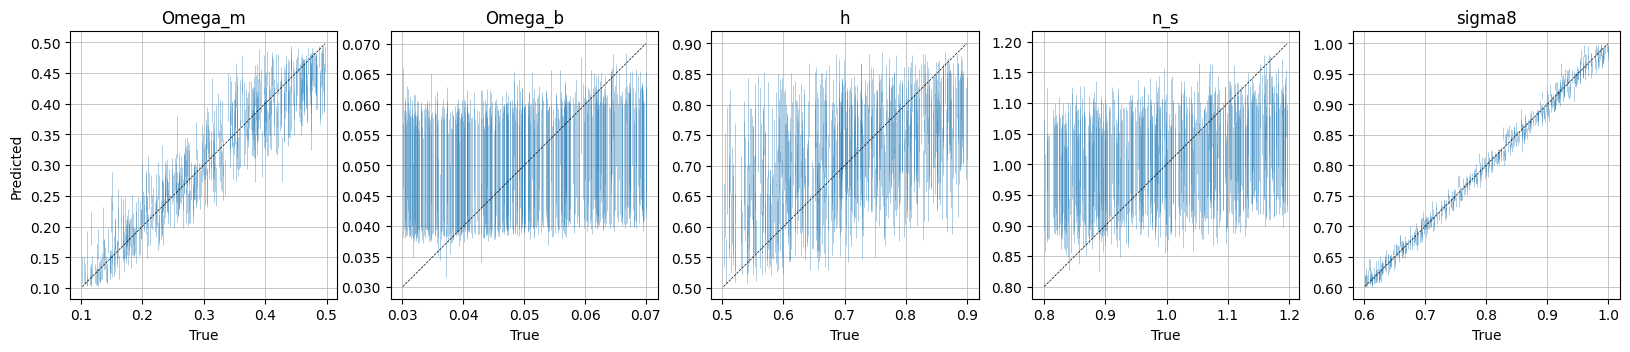

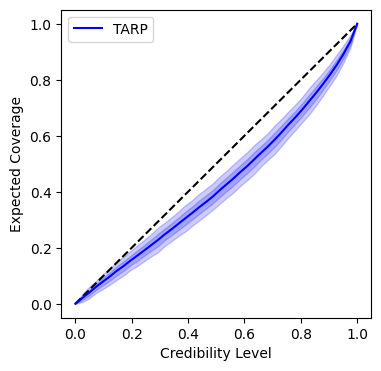

In [26]:
# Drawing samples from the ensemble posterior
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble.posteriors[0], # NeuralPosteriorEnsemble instance from sbi package
    x=X_rho_test, theta=Theta_rho_test
)

# 2) Halos Inference
This time, we can either take an Abacus simulation as the observation or one of the 2Gpc runs

Note: halos.h5 files do not have a "k" key. since the Pk* shapes are the same as for rho, I will assume the corresponding k wavevector is the same as for rho.

## 2-1) Power spectrum real space

In [68]:
def load_pk_halos(my_path, seed_int, k_min, k_max, k_arr, stat_str, col = 0, key_main = main_key):
    # col = 0 to load power spectrum monopole by default
    temp  = h5py.File(my_path + "%s/diag/halos.h5"%str(seed_int), "r")
    data_temp = temp[key_main]

    inds0 = np.where((k_arr[:]>=k_min) & (k_arr[:]<=k_max))[0]
    if stat_str != "Pk_k":
        return data_temp[stat_str][inds0, col] 
    else:
        return data_temp[stat_str][inds0] 

In [69]:
# Construct the X array for ltu-ili InferenceRunner
k_low = 1e-2
k_up = 0.3
pk_pole = 0 # for monopole
stath = "Pk"

# Actually fill-in data
pks_h = np.zeros((len(inter_list), p_vec), dtype = np.float32)

nn = 0
for si in tqdm(inter_list):
    pks_h[nn,:] = load_pk_halos(matt_path, si, k_low, k_up, k_temp, stath,col = pk_pole)
    nn+=1

# Filter out null values (as in Matt's inference notebook)
mask = np.all(pks_h==0, axis=1)
pks_h = pks_h[~mask]
Theta_h = Theta[~mask]

100%|██████████| 1614/1614 [00:04<00:00, 353.07it/s]


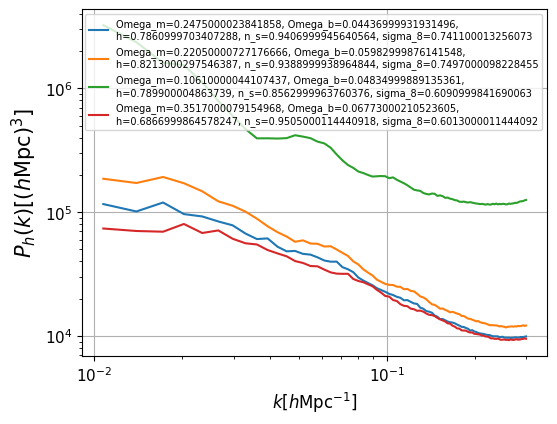

In [70]:
# Sanity check plot
A = plt.figure(figsize = (6,4.5))
for i in [16,23,1312, 916]:
    lstr = f"Omega_m={Theta_h[i,0]}, Omega_b={Theta_h[i,1]}, \n"
    lstr += f"h={Theta_h[i,2]}, n_s={Theta_h[i,3]}, sigma_8={Theta_h[i,4]}"
    plt.loglog(k_vec, pks_h[i,:], label=lstr)
plt.legend(fontsize=7)
plt.grid()
plt.xlabel(r"$k[h\mathrm{Mpc}^{-1}]$", fontsize = 12)
plt.ylabel(r"$P_h(k)[(h\mathrm{Mpc})^{3}]$", fontsize = 15)
plt.tick_params(labelsize = 11)

In [72]:
# Split data into train, validation (posterior coverage and cie) and observation.

# Perhaps transform data vector
f_h = lambda pk : np.log10(pk)

# Observation
abacus_obs = True
abacus_sim = 139

if abacus_obs:
    with open(abacus_path + str(abacus_sim) + "/config.yaml", "r") as file:
        print("OBSERVATION = ABACUS SIM")
        run_info = yaml.safe_load(file)
        theta_0 = np.array(run_info["nbody"]["cosmo"], dtype = np.float32)
        x_0 =  f_h(load_pk_halos(abacus_path, abacus_sim, k_low, k_up, k_temp, stath,col = pk_pole))
        pks_halos = pks_h
        Theta_halos = Theta_h
else:
    obs_ind = 982
    x_0 = f_h(pks_h[obs_ind, :])
    theta_0 = Theta_h[obs_ind,:]
    pks_halos = np.delete(pks_h, obs_ind, axis = 0)
    Theta_halos = np.delete(Theta_h, obs_ind, axis = 0)
    
print(theta_0) 

n_train = 1200
X_halos_train = f_h(pks_halos[:n_train,:])
Theta_halos_train = Theta_halos[:n_train,:]

n_test = len(inter_list) - n_train - 1 ; print("We have %i test sims left"%n_test) # accounting for observation
X_halos_test = f_h(pks_halos[n_train:,:])
Theta_halos_test = Theta_halos[n_train:,:]

# Instantiante ILI runner                   
loader_h = NumpyLoader(x=X_halos_train, theta=Theta_halos_train)

OBSERVATION = ABACUS SIM
[0.13696  0.02416  0.7164   0.9732   0.793003]
We have 413 test sims left


In [73]:

activation = "ReLU"
n_hidden = [128, 64, 32]
my_embedding_halos = FCN(n_hidden = n_hidden, act_fn = activation)
#my_embedding_halos = None

#instantiate your neural networks to be used as an ensemble
backend = "sbi"
engine = "NPE"
signatures = ["maf_test","mdn_test"]
hidden_mdn = 50
componenents_mdn = 6
hidden_maf = 50
transforms_maf = 10
nets_rho = [
    ili.utils.load_nde_sbi(engine=engine, model='maf', hidden_features=hidden_maf, num_transforms=transforms_maf),
    ili.utils.load_nde_sbi(engine=engine, model='mdn', hidden_features=hidden_mdn, num_components=componenents_mdn)
]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-4,
    'validation_fraction':0.1
}

# initialize the trainer
runner_halos = InferenceRunner.load(
    backend=backend,
    engine=engine,
    prior=prior,
    nets=nets_rho,
    device=device,
    embedding_net=my_embedding_halos,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [74]:
# train the model
posterior_ensemble, summaries = runner_halos(loader=loader_h)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 302 epochs.

INFO:root:Training model 2 / 2.


 Training neural network. Epochs trained: 165

/home/chartier/myModules/miniconda/envs/cmass_val/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 114.58507585525513 seconds to train models.


 Neural network successfully converged after 166 epochs.

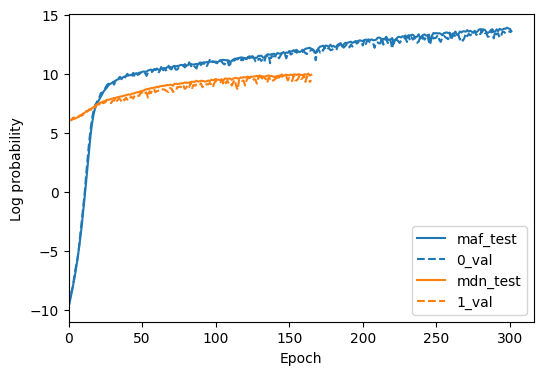

In [75]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f"C{i}" for i in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=signatures[i], c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

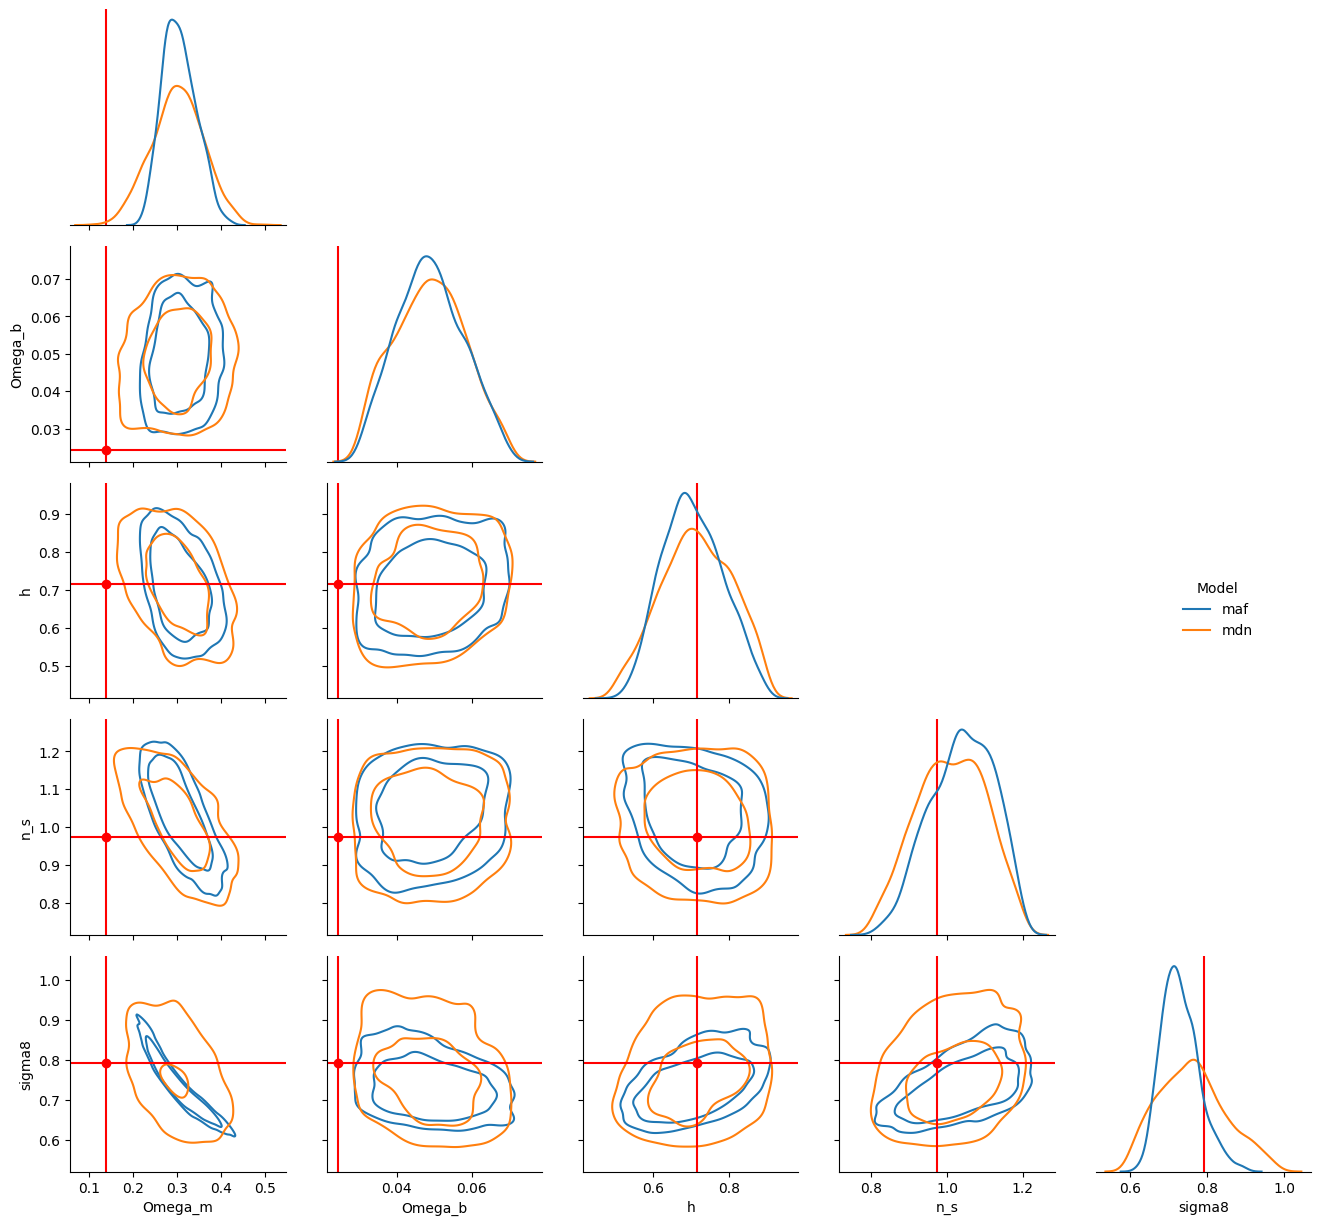

In [76]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x_0, theta_fid=theta_0,
    name='maf'
)
# overplot the posterior for model #2 (MDN)
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x_obs = x_0, theta_fid=theta_0,
    name='mdn',
    grid=fig  # overplot on the same figure
)

100%|██████████| 100/100 [00:04<00:00, 22.98it/s]


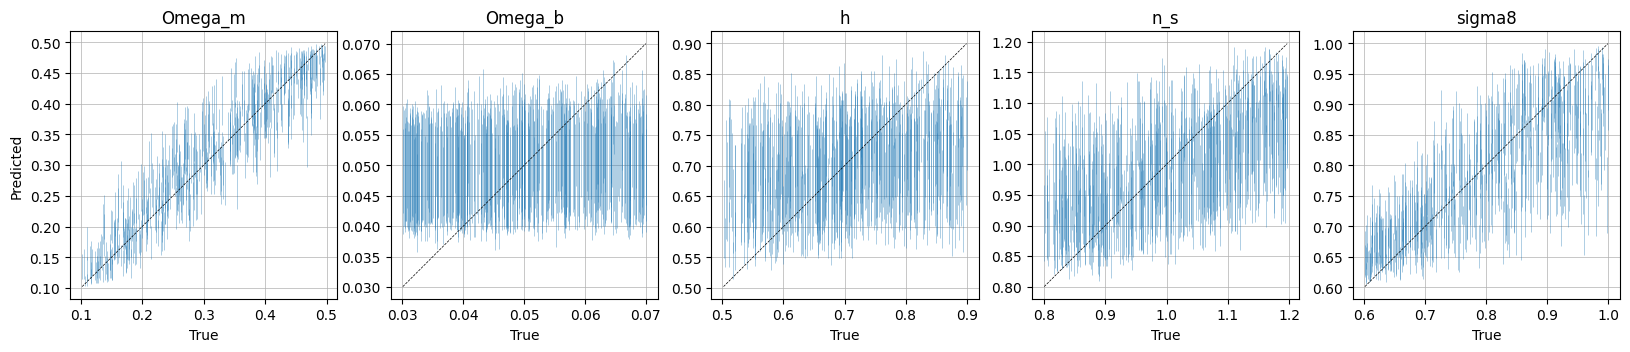

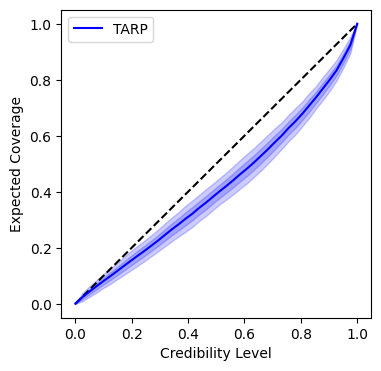

In [79]:
# Drawing samples from the ensemble posterior
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble.posteriors[0], # NeuralPosteriorEnsemble instance from sbi package
    x=X_halos_test, theta=Theta_halos_test
)

## 2-2) Power spectrum redshift space
TODO?

# 3) Galaxies Inference

In [80]:
def load_pk_gal(my_path, seed_int, my_hod, k_min, k_max, k_arr, stat_str, col = 0, key_main = main_key):
    # col = 0 to load power spectrum monopole by default
    temp  = h5py.File(my_path + "%s/diag/galaxies/%s.h5"%(str(seed_int), my_hod), "r")
    data_temp = temp[key_main]

    inds0 = np.where((k_arr[:]>=k_min) & (k_arr[:]<=k_max))[0]
    if stat_str != "Pk_k":
        return data_temp[stat_str][inds0, col] 
    else:
        return data_temp[stat_str][inds0] 

In [81]:
# Construct the X array for ltu-ili InferenceRunner
k_low = 1e-2
k_up = 0.3
pk_pole = 0 # for monopole
statg = "Pk"

# Actually fill-in data
pks_g = np.zeros((len(inter_list), p_vec), dtype = np.float32)

nn = 0
for si in tqdm(inter_list):
    pks_g[nn,:] = load_pk_gal(matt_path, si,hod_str, k_low, k_up, k_temp, statg,col = pk_pole)
    nn+=1

# Filter out null values (as in Matt's inference notebook)
mask = np.all(pks_g==0, axis=1)
pks_g = pks_g[~mask]
Theta_g = Theta[~mask]

100%|██████████| 1614/1614 [00:25<00:00, 63.46it/s]


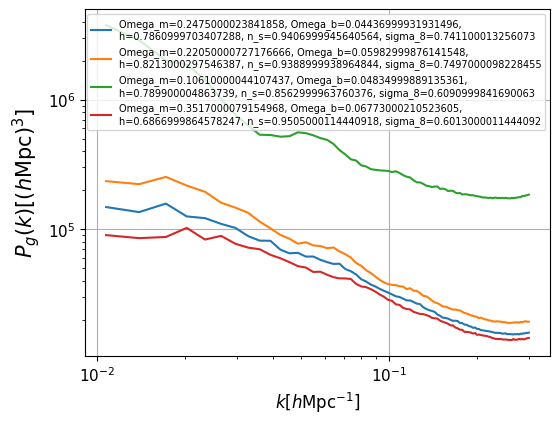

In [82]:
# Sanity check plot
A = plt.figure(figsize = (6,4.5))
for i in [16,23,1312, 916]:
    lstr = f"Omega_m={Theta_g[i,0]}, Omega_b={Theta_g[i,1]}, \n"
    lstr += f"h={Theta_g[i,2]}, n_s={Theta_g[i,3]}, sigma_8={Theta_g[i,4]}"
    plt.loglog(k_vec, pks_g[i,:], label=lstr)
plt.legend(fontsize=7)
plt.grid()
plt.xlabel(r"$k[h\mathrm{Mpc}^{-1}]$", fontsize = 12)
plt.ylabel(r"$P_g(k)[(h\mathrm{Mpc})^{3}]$", fontsize = 15)
plt.tick_params(labelsize = 11)

In [83]:
# Split data into train, validation (posterior coverage and cie) and observation.

# Perhaps transform data vector
f_g = lambda pk : np.log10(pk)

# Observation
abacus_obs = True
abacus_sim = 131

if abacus_obs:
    with open(abacus_path + str(abacus_sim) + "/config.yaml", "r") as file:
        print("OBSERVATION = ABACUS SIM")
        run_info = yaml.safe_load(file)
        theta_0 = np.array(run_info["nbody"]["cosmo"], dtype = np.float32)
        x_0 =  f_g(load_pk_gal(abacus_path, abacus_sim,hod_str, k_low, k_up, k_temp, statg ,col = pk_pole))
        pks_gal = pks_g
        Theta_gal = Theta_g
else:
    obs_ind = 982
    x_0 = f_g(pks_g[obs_ind, :])
    theta_0 = Theta_g[obs_ind,:]
    pks_gal = np.delete(pks_g, obs_ind, axis = 0)
    Theta_gal = np.delete(Theta_g, obs_ind, axis = 0)
    
print(theta_0) 


n_train = 1200
X_gal_train = f_g(pks_gal[:n_train,:])
Theta_gal_train = Theta_gal[:n_train,:]

n_test = len(inter_list) - n_train - 1 ; print("We have %i test sims left"%n_test) # accounting for observation
X_gal_test = f_g(pks_gal[n_train:,:])
Theta_gal_test = Theta_gal[n_train:,:]

# Instantiante ILI runner                   
loader_g = NumpyLoader(x=X_gal_train, theta=Theta_gal_train)

OBSERVATION = ABACUS SIM
[0.13097  0.02237  0.7165   0.9649   0.807866]
We have 413 test sims left


In [84]:
activation = "ReLU"
n_hidden = [128, 64, 32]
#my_embedding_gal = FCN(n_hidden = n_hidden, act_fn = activation)
my_embedding_gal = None

#instantiate your neural networks to be used as an ensemble
backend = "sbi"
engine = "NPE"
signatures = ["maf_test","mdn_test"]
hidden_mdn = 50
componenents_mdn = 6
hidden_maf = 50
transforms_maf = 10
nets_rho = [
    ili.utils.load_nde_sbi(engine=engine, model='maf', hidden_features=hidden_maf, num_transforms=transforms_maf),
    ili.utils.load_nde_sbi(engine=engine, model='mdn', hidden_features=hidden_mdn, num_components=componenents_mdn)
]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 1e-4,
    'validation_fraction':0.1
}

# initialize the trainer
runner_gal = InferenceRunner.load(
    backend=backend,
    engine=engine,
    prior=prior,
    nets=nets_rho,
    device=device,
    embedding_net=my_embedding_gal,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [85]:
# train the model
posterior_ensemble, summaries = runner_gal(loader=loader_g)

INFO:root:MODEL INFERENCE CLASS: NPE
/home/chartier/myModules/miniconda/envs/cmass_val/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
INFO:root:Training model 1 / 2.


 Neural network successfully converged after 254 epochs.

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 104 epochs.

/home/chartier/myModules/miniconda/envs/cmass_val/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)
INFO:root:It took 81.552814245224 seconds to train models.


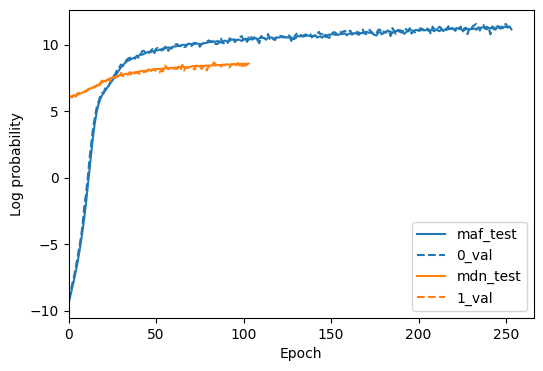

In [86]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f"C{i}" for i in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=signatures[i], c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

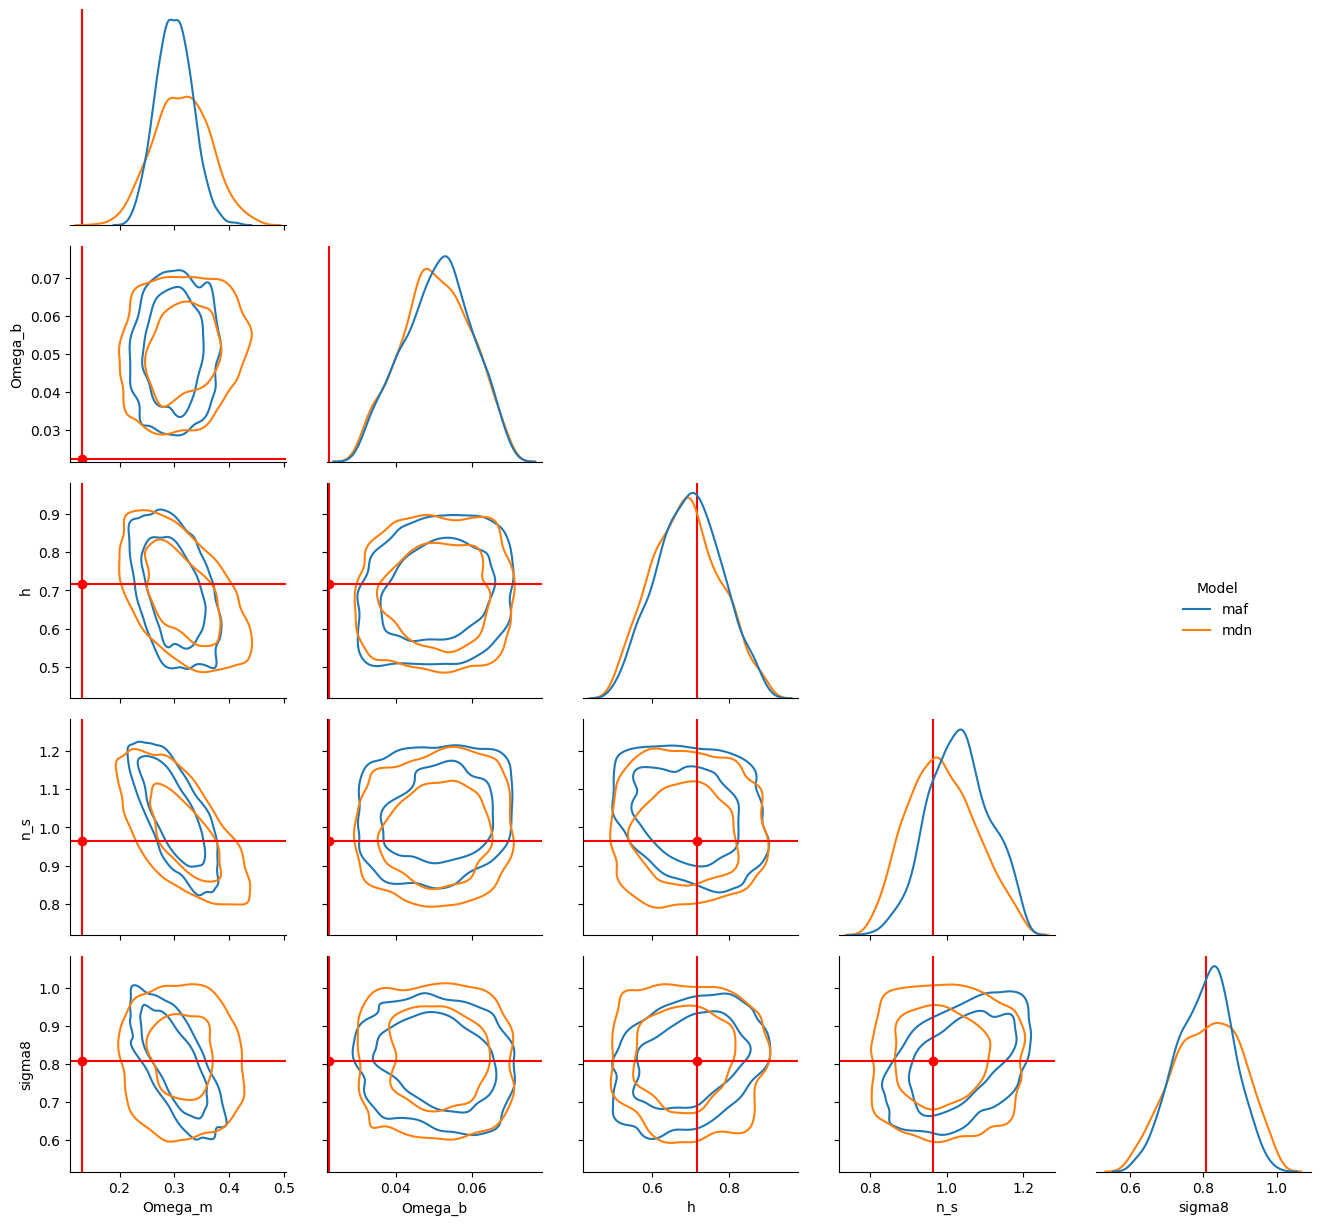

In [87]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
)

# plot the posterior for model #1 (MAF)
fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x_obs = x_0, theta_fid=theta_0,
    name='maf'
)
# overplot the posterior for model #2 (MDN)
fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x_obs = x_0, theta_fid=theta_0,
    name='mdn',
    grid=fig  # overplot on the same figure
)

 21%|██        | 63/300 [00:02<00:09, 26.16it/s]WARNING:root:Only 0.855% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    906 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
100%|██████████| 100/100 [00:02<00:00, 38.12it/s]


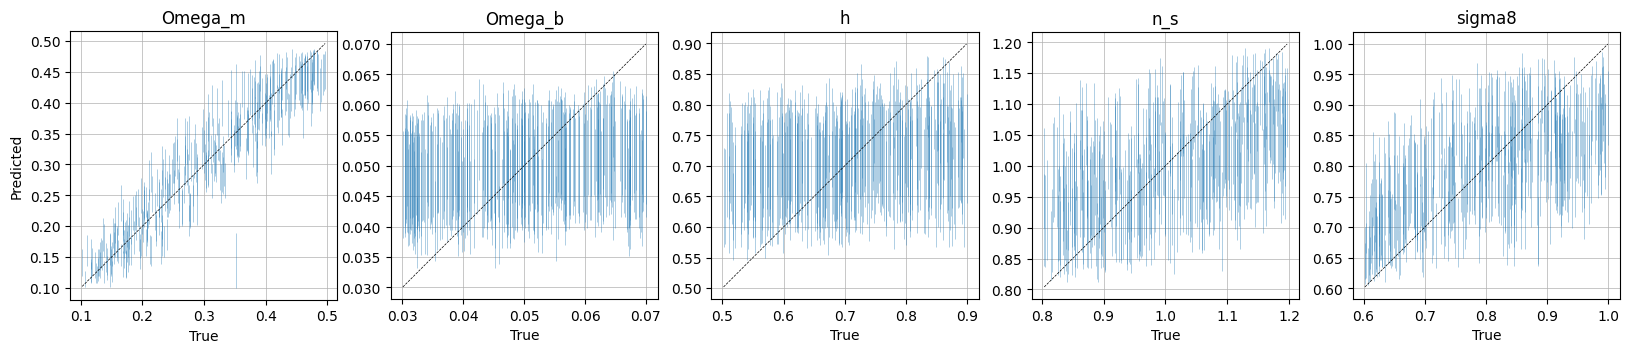

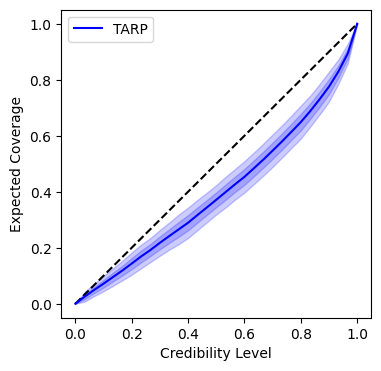

In [90]:
# Drawing samples from the ensemble posterior
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble.posteriors[0], # NeuralPosteriorEnsemble instance from sbi package
    x=X_gal_test[:300,:], theta=Theta_gal_test[:300,:]
)

# Misc.

In [37]:
# Examine halo file
test1 = h5py.File(matt_path + "1111/diag/rho.h5", "r")
klk1 = retrieve_keys(test1)
print(test1[klk1[0]].keys())
print(test1[klk1[0]]["k"].shape)

<KeysViewHDF5 ['Pk', 'k']>
(221,)


In [35]:
# Examine halo file
test2 = h5py.File(matt_path + "1111/diag/halos.h5", "r")
klk2 = retrieve_keys(test2)
print(test2[klk2[0]].keys())
print(test2[klk2[0]]["Pk_k"].shape)
print(test2[klk2[0]]["Pk"].shape)
print(test2[klk2[0]]["Pk"].shape)

<KeysViewHDF5 ['Pk', 'Pk_k', 'mass_bins', 'mass_hist', 'zPk', 'zPk_k']>
(221,)
(221, 3)
(221, 3)


In [44]:
# Examine galaxy file, one particular HOD
test3 = h5py.File(matt_path + "1111/diag/galaxies/hod00000.h5", "r")
klk3 = retrieve_keys(test3)
print(test3[klk3[0]].keys())
print(test3[klk3[0]]["Pk_k"].shape)
print(test3[klk3[0]]["Pk"].shape)
print(test3[klk3[0]]["Pk"].shape)

<KeysViewHDF5 ['Pk', 'Pk_k', 'zPk', 'zPk_k']>
(221,)
(221, 3)
(221, 3)
